# Content based filtering

There are 2 aproximations:
- Filter songs by energy and recomend
- Recomend and chose song of recomended list based on energy

We decide to use the second one due to better scalability and performance

## Data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
RANDOM_STATE = 123

In [2]:
df_music = pd.read_csv('data/Million Song Dataset kaggle/Music Info.csv')

In [3]:
df_music.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


In [4]:
df_music_info = df_music[['track_id', 'name', 'artist', 'energy']]

In [5]:
df_users_raw = pd.read_csv('data/Million Song Dataset kaggle/User Listening History.csv')

We only take into account users that have listened to at least 5 songs

In [6]:
df_user_counts = df_users_raw['user_id'].value_counts().reset_index()
df_user_counts.columns = ['user_id', 'count']
df_user_counts

,user_id,count
0,ec6dfcf19485cb011e0b22637075037aae34cf26,784
1,4e11f45d732f4861772b2906f81a7d384552ad12,384
2,726da71c2c2ea119119a7957517fccd028d1be76,376
3,113255a012b2affeab62607563d03fbdf31b08e7,367
4,7adec7f006cb09482d36609d205293d8b61f030e,366
...,...,...
962032,19e70c61de7bbb0ca3fc39c81a7e6b7eede69aa1,1
962033,7154895e6b692062033eecb3fe59ad240bb02811,1
962034,5d563bc9f80ddb3bce489c84b453409a88bd37e9,1
962035,779074ba35bd5f14913635819233a01dc5ecc9de,1


In [7]:
df_users = df_users_raw[df_users_raw['user_id'].isin(df_user_counts[df_user_counts['count'] > 5]['user_id'])].reset_index(drop=True)

In [8]:
user_codes, user_uniques = pd.factorize(df_users['user_id'])
track_codes, track_uniques = pd.factorize(df_users['track_id'])

In [9]:
data_df = df_users_raw.groupby('track_id').size().reset_index(name='count')

In [10]:
df_music.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'tags', 'genre', 'year', 'duration_ms', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [11]:
used_features = ['danceability', 'key','loudness', 'mode', 
                 'speechiness', 'acousticness', 'instrumentalness',
                 'liveness', 'valence', 'tempo']

In [12]:
X = df_music[used_features].copy()

In [13]:
X.dtypes

danceability        float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
dtype: object

In [14]:
len(X['key'].unique())

12

In [15]:
X['key_cos'] = np.cos(2 * np.pi * X['key'] / len(X['key'].unique()))
X['key_sin'] = np.sin(2 * np.pi * X['key'] / len(X['key'].unique()))

In [16]:
X.drop(columns=['key'], inplace=True)

In [17]:
X

,danceability,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key_cos,key_sin
0,0.355,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,8.660254e-01,5.000000e-01
1,0.409,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,5.000000e-01,8.660254e-01
2,0.508,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,-5.000000e-01,8.660254e-01
3,0.279,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,-1.836970e-16,-1.000000e+00
4,0.515,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,-8.660254e-01,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...
50678,0.438,-3.062,0,0.1650,0.003120,0.000000,0.1300,0.421,166.956,-1.000000e+00,1.224647e-16
50679,0.351,-6.811,1,0.1200,0.000940,0.000049,0.1920,0.450,200.350,1.000000e+00,0.000000e+00
50680,0.434,-3.092,0,0.2680,0.000108,0.001410,0.1630,0.282,158.025,5.000000e-01,-8.660254e-01
50681,0.513,-3.914,0,0.0530,0.000715,0.001350,0.0571,0.618,109.923,-5.000000e-01,8.660254e-01


In [18]:
X.isnull().sum()

danceability        0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
key_cos             0
key_sin             0
dtype: int64

In [19]:
X.columns

Index(['danceability', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'key_cos',
       'key_sin'],
      dtype='object')

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-0.77465639,  0.86431996,  0.76461498, -0.01871828, -0.70206668,
        -0.66840546, -0.64065066, -0.74633372,  0.83070987,  1.12939497,
         0.77857178],
       [-0.47270445,  0.86146176,  0.76461498, -0.55814479, -0.70333136,
        -0.66840546, -0.04561469,  0.84190729,  1.7190036 ,  0.62340701,
         1.31075271],
       [ 0.08087409,  0.55145719, -1.30784777, -0.47394163, -0.70541823,
        -0.66704363, -0.69100403,  0.42455929, -0.1180143 , -0.75897782,
         1.31075271],
       [-1.19962577, -0.12307757,  0.76461498, -0.51209619, -0.7047116 ,
        -0.66646211, -0.44627585,  0.21974962, -0.63967418, -0.06778541,
        -1.40234622],
       [ 0.12001601, -0.36140732,  0.76461498, -0.51472754, -0.67231553,
        -0.66798712, -0.46793322, -1.27188305, -1.06906792, -1.26496578,
        -0.67537355]])

In [22]:
# Pares indice track_id
id_to_index = pd.Series(df_music.index.values, index=df_music['track_id'])
index_to_id = pd.Series(df_music['track_id'].values, index=df_music.index)
index_to_energy = pd.Series(df_music['energy'].values, index=df_music.index)

In [23]:
id_to_index[['TRIOREW128F424EAF0', 'TROUVHL128F426C441']].values

array([0, 2])

In [24]:
index_to_id[id_to_index[['TRIOREW128F424EAF0', 'TROUVHL128F426C441']].values].values

array(['TRIOREW128F424EAF0', 'TROUVHL128F426C441'], dtype=object)

In [25]:
index_to_energy[id_to_index[['TRIOREW128F424EAF0', 'TROUVHL128F426C441']].values].values

array([0.918, 0.826])

## Cosine similarity

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
class CosineContentBasedRecommender: #For user history
    def __init__(self, X_scaled, id_to_index, index_to_id, index_to_energy):
        self.X_scaled = X_scaled
        self.id_to_index = id_to_index
        self.index_to_id = index_to_id
        self.index_to_energy = index_to_energy
        self.recommendations = None #index, track_id, energy, similarity, has_been_recommended
    
    def make_recommendations(self, user_history, top_n=10):
        user_history_indexes = self.id_to_index[user_history].values
        user_vector = np.mean(self.X_scaled[user_history_indexes], axis=0).reshape(1, -1)

        similarities = cosine_similarity(user_vector, self.X_scaled)[0]
        
        #If item in user history, set similarity to -inf
        for idx in user_history_indexes:
            similarities[idx] = -np.inf

        top_n_indices = np.argpartition(similarities, -top_n)[-top_n:]
        top_indices = top_n_indices[np.argsort(similarities[top_n_indices])[::-1]]

        # Pairs index, similarity[index]
        self.recommendations = [(index, index_to_id[index], index_to_energy[index], similarities[index], False) for index in top_indices]


    def recommend_song(self, energy, energy_margin=0.05):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        
        closest_track_index = None
        distance_to_energy = float('inf')

        for i, (track_index, track_id, track_energy, has_been_recommended) in enumerate(self.recommendations):
            distance = abs(track_energy - energy)

            if not has_been_recommended and distance <= energy_margin:
                self.recommendations[i] = (track_index,track_id, track_energy, True)
                return (track_index, track_id, track_energy)
            
            if not has_been_recommended and distance < distance_to_energy:
                closest_track_index = i
                distance_to_energy = distance
        
        if closest_track_index is not None:
            track_id, track_energy, _ = self.recommendations[closest_track_index]
            self.recommendations[closest_track_index] = (track_index,track_id, track_energy, True)
            return (track_index, track_id, track_energy)

        raise ValueError("All recommendations have already been recommended")
    
    def get_recommendations(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return self.recommendations


    def get_recommendations_ids(self):
        if self.recommendations is None:
            raise ValueError("No recommendations available. Please call make_recommendations first.")
        return [track_id for _, track_id, _, _, _ in self.recommendations]
    

Example

In [28]:
user_index = 0
user_id = df_users['user_id'].unique()[user_index]
user_history = df_users[df_users['user_id'] == user_id]['track_id'].values
user_history

array(['TRIRLYL128F42539D1', 'TRFUPBA128F934F7E1', 'TRLQPQJ128F42AA94F',
       'TRTUCUY128F92E1D24', 'TRHDDQG12903CB53EE', 'TRGRDEC128F423C07D',
       'TRRYCBO128F932A2C7', 'TRUTULC128F4293712', 'TRAAHSY128F147BB5C',
       'TRDLMWP128F426BF6C', 'TRMSZXT128F92F7816', 'TRVODUZ128F934D094',
       'TRLXSNR128F429361D', 'TRPUGUW128F426BF6F', 'TRAUCNU128F42671EB',
       'TRVVWSW128F4292931', 'TRADVZX128F426BF79', 'TRDCZUX128F4263A74',
       'TRUYKTB128F1459197', 'TRQLOHS128F42435AE'], dtype=object)

In [29]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_info[df_music_info['track_id'].isin(user_listened_songs)]

,track_id,name,artist,energy
79,TRAAHSY128F147BB5C,Speed of Sound,Coldplay,0.8980
796,TRDLMWP128F426BF6C,Ragged Wood,Fleet Foxes,0.6850
1158,TRPUGUW128F426BF6F,He Doesn't Know Why,Fleet Foxes,0.5580
1743,TRRYCBO128F932A2C7,Love Shack,The B-52's,0.9020
2350,TRFUPBA128F934F7E1,Paper Gangsta,Lady Gaga,0.5300
2585,TRVODUZ128F934D094,All That We Perceive,Thievery Corporation,0.8340
2722,TRHDDQG12903CB53EE,Heaven's Gonna Burn Your Eyes,Thievery Corporation,0.3370
5416,TRTUCUY128F92E1D24,Stacked Actors,Foo Fighters,0.9340
5428,TRLXSNR128F429361D,Generator,Foo Fighters,0.9240
5819,TRADVZX128F426BF79,Sun Giant,Fleet Foxes,0.0626


In [30]:
cosine_content_recommender = CosineContentBasedRecommender(X_scaled, id_to_index, index_to_id, index_to_energy)
cosine_content_recommender.make_recommendations(user_history, top_n=20)
recomendations = cosine_content_recommender.get_recommendations_ids()
df_music_info[df_music_info['track_id'].isin(recomendations)].head(20)

,track_id,name,artist,energy
1073,TRMKKFV12903CB7EA4,Flake,Jack Johnson,0.657
4071,TRRLSNM12903CE009D,Theologians,Wilco,0.715
4302,TRNRKTX12903CD9FE0,Long Haul,Voxtrot,0.702
5156,TROQQRZ128F4296636,Fidelity,Regina Spektor,0.513
5263,TRILPCS12903CE3C6C,Vultures,John Mayer,0.478
6360,TRFRMJC128F428D15C,Hold Me Now,Thompson Twins,0.711
6627,TRFOVFC12903CA1A4E,Stuck in the Middle,Mika,0.565
9014,TRIHULI128F931F600,My Favorite Part,Mac Miller,0.330
9198,TRUNYZG128F4284491,Palm of Your Hand,Cake,0.520
12464,TRRHXZX128F93191C4,Cubism Dream,Local Natives,0.526


## Clustering

Penalizar a las canciones recomendadas por el collaborative que no estén en el cluster

### PCA

In [31]:
from sklearn.decomposition import PCA


Test with 2 dimensions for better cluster visualitation

In [32]:
pca = PCA(n_components=2)
pca.fit(X_scaled)
X_reduced_2d = pca.transform(X_scaled)
X_reduced_2d[:5]

array([[ 0.69330498, -1.15195534],
       [ 1.53228666, -0.5118226 ],
       [ 0.82421544,  0.26070896],
       [ 0.07070129, -0.23054541],
       [-0.48249746,  0.01361195]])

We obtain the optimal number of clusters using the elbow method and Davies-Bouldin index

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
max_k = 15

wcss, db, silh = [], [], []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_reduced_2d)
    wcss.append(kmeans.inertia_)
    
    #Davies-Bouldin score
    db.append(davies_bouldin_score(X_reduced_2d, kmeans.labels_))

    #Silhouette score
    #Too much time to compute
    #silh.append(silhouette_score(X_reduced_2d, kmeans.labels_))



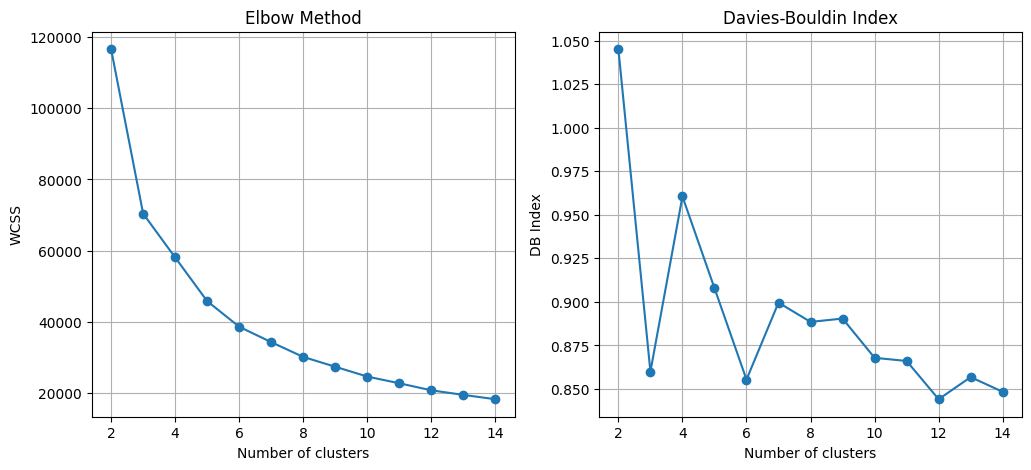

In [54]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k), db, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('DB Index')
plt.grid()
plt.show()

Observing the graphs we select 6 clusters

In [35]:
kmeans_reduced_2d = KMeans(n_clusters=6, random_state=RANDOM_STATE)
df_kmeans_2d = df_music.copy()
df_kmeans_2d['Cluster'] = kmeans_reduced_2d.fit_predict(X_reduced_2d)
df_kmeans_2d.head()


,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4,0
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4,3
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4,3
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4,3
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4,4


In [36]:
df_kmeans_2d['Cluster'].value_counts()

Cluster
3    14032
1    10145
4     7786
0     7623
5     7351
2     3746
Name: count, dtype: int64

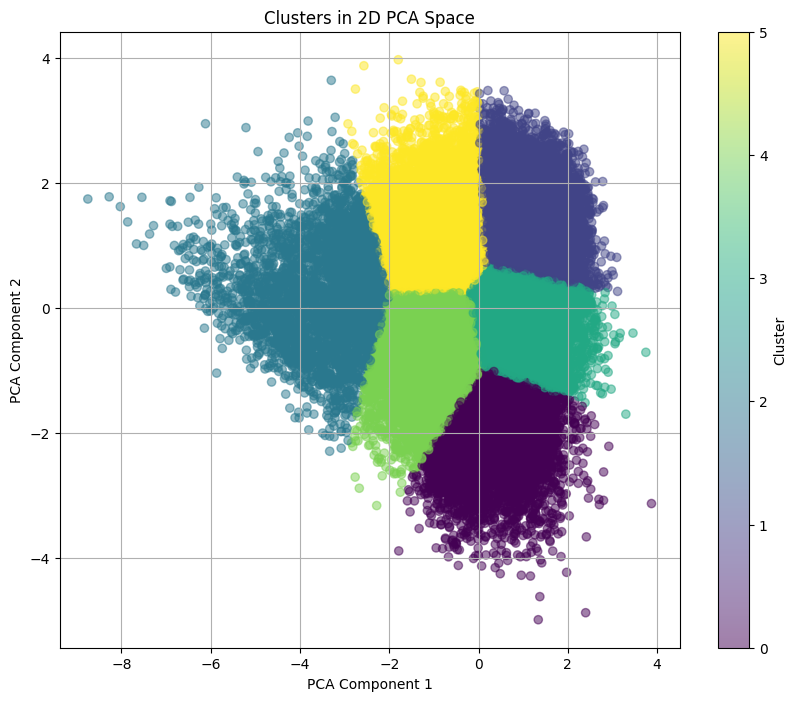

In [37]:
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced_2d[:, 0], X_reduced_2d[:, 1], c=df_kmeans_2d['Cluster'], cmap='viridis', alpha=0.5)
plt.title('Clusters in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

#### Optimal dimensions

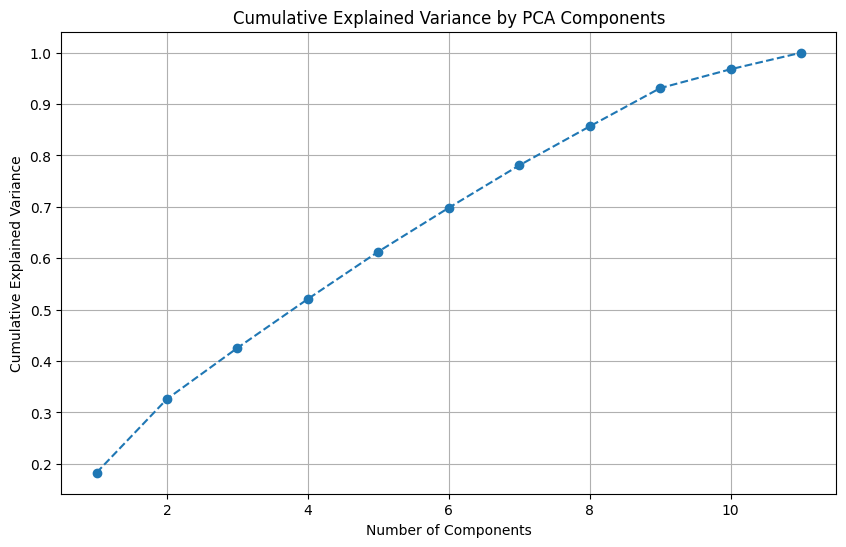

In [38]:
pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

We select 9 dimensions as a good compromise between number of variables and cumulative expalained variance. With 9 dimensions, the variance is over 90% and after that it begins to increase slower.

In [39]:
pca = PCA(n_components=9)
pca.fit(X_scaled)
X_reduced_opt = pca.transform(X_scaled)
X_reduced_opt[:5]

array([[ 6.93304984e-01, -1.15195534e+00,  1.70414270e+00,
        -8.53666425e-01,  8.66917400e-02, -3.00418672e-01,
        -1.48829030e-01, -3.74064662e-01, -8.06697634e-01],
       [ 1.53228666e+00, -5.11822596e-01,  1.78409538e+00,
        -1.07435625e+00,  2.78706356e-01,  1.62762757e-02,
         9.24898330e-01,  7.47935145e-01, -9.36060458e-02],
       [ 8.24215439e-01,  2.60708964e-01, -5.30398247e-05,
        -6.57897083e-01, -8.76249353e-01,  1.87935801e+00,
         5.02584121e-01, -1.97606963e-01, -5.18095865e-01],
       [ 7.07012932e-02, -2.30545407e-01, -3.74226733e-01,
        -6.04884357e-01,  1.20742832e+00, -2.93612483e-01,
        -1.45151999e+00, -1.10935441e-01, -4.39611786e-01],
       [-4.82497457e-01,  1.36119535e-02, -6.99511858e-01,
        -3.01060742e-01,  1.41693927e+00,  8.32263516e-01,
        -9.66588145e-01, -9.32440449e-01, -2.53456329e-01]])

### Clustering system

We study the optimal number of clusters

In [40]:
max_k = 19

wcss, db, silh = [], [], []

for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X_reduced_opt)
    wcss.append(kmeans.inertia_)
    
    #Davies-Bouldin score
    db.append(davies_bouldin_score(X_reduced_opt, kmeans.labels_))

    #Silhouette score
    #silh.append(silhouette_score(X_reduced_opt, kmeans.labels_))

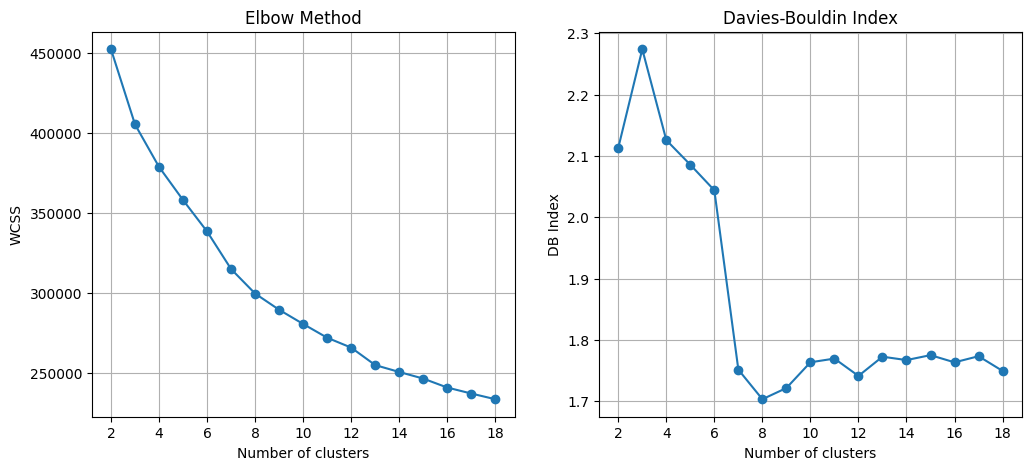

In [41]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(2, max_k), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k), db, marker='o')
plt.title('Davies-Bouldin Index')
plt.xlabel('Number of clusters')
plt.ylabel('DB Index')
plt.grid()
plt.show()

We select 8 as the optimal cluster number

We obtenein the clsuter of each song. This is a precalculation, so we dont need to do it in every single recommendation.

In [42]:
kmeans_reduced_opt = KMeans(n_clusters=8, random_state=RANDOM_STATE)
df_music_kmeans_opt = df_music.copy()
final_cluster_predictions = kmeans_reduced_opt.fit_predict(X_reduced_opt)
df_music_kmeans_opt['Cluster'] = final_cluster_predictions
df_music_kmeans_opt.head()

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Cluster
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4,3
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4,2
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4,2


In [43]:
df_music_kmeans_opt['Cluster'].value_counts()

Cluster
3    8265
4    8230
1    8156
2    7289
6    7104
5    6367
7    3182
0    2090
Name: count, dtype: int64

We reduce de data to 2 dimensions for visualization

In [56]:
pca = PCA(n_components=2)
pca.fit(X_reduced_opt)
X_reduced_2d_opt = pca.transform(X_reduced_opt)

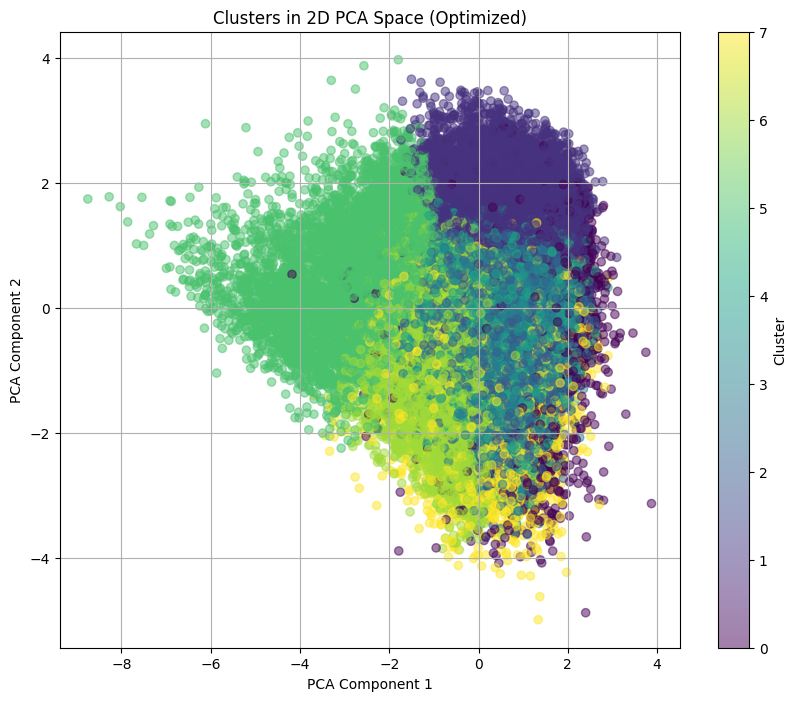

In [57]:
plt.figure(figsize=(10, 8))
plt.scatter(X_reduced_2d_opt[:, 0], X_reduced_2d_opt[:, 1], c=final_cluster_predictions, cmap='viridis', alpha=0.5)
plt.title('Clusters in 2D PCA Space (Optimized)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

In [44]:
id_to_cluster = pd.Series(df_music_kmeans_opt['Cluster'].values, index=df_music['track_id'])

In [45]:
id_to_cluster.to_csv('data/track_clusters.csv', index=True, header=True)

TODO hacer lo de la eleccion de canciones aleatorias de un cluster

In [46]:
class KmeansContentBasedRecommender: #For user history
    def __init__(self, id_to_cluster):
        self.id_to_cluster = id_to_cluster
        self.recommendations = None
    
    def make_cluster_recommendation(self, user_history):
        clusters = self.id_to_cluster[user_history]
        cluster_counts = clusters.value_counts()
        self.recommendations = cluster_counts / len(clusters)

    def get_recommended_cluster(self):
        if self.recommendations is None:
            raise ValueError("No cluster recommendation available. Please call make_cluster_recommendation first.")
        return self.recommendations
    

Example

In [47]:
user_index = 0
user_id = df_users['user_id'].unique()[user_index]
user_history = df_users[df_users['user_id'] == user_id]['track_id'].values
user_history

array(['TRIRLYL128F42539D1', 'TRFUPBA128F934F7E1', 'TRLQPQJ128F42AA94F',
       'TRTUCUY128F92E1D24', 'TRHDDQG12903CB53EE', 'TRGRDEC128F423C07D',
       'TRRYCBO128F932A2C7', 'TRUTULC128F4293712', 'TRAAHSY128F147BB5C',
       'TRDLMWP128F426BF6C', 'TRMSZXT128F92F7816', 'TRVODUZ128F934D094',
       'TRLXSNR128F429361D', 'TRPUGUW128F426BF6F', 'TRAUCNU128F42671EB',
       'TRVVWSW128F4292931', 'TRADVZX128F426BF79', 'TRDCZUX128F4263A74',
       'TRUYKTB128F1459197', 'TRQLOHS128F42435AE'], dtype=object)

In [48]:
user_listened_songs = df_users[df_users['user_id'] == user_uniques[user_index]].track_id
df_music_kmeans_opt[df_music_info['track_id'].isin(user_listened_songs)][['track_id', 'name', 'artist', 'energy', 'Cluster']]

,track_id,name,artist,energy,Cluster
79,TRAAHSY128F147BB5C,Speed of Sound,Coldplay,0.8980,3
796,TRDLMWP128F426BF6C,Ragged Wood,Fleet Foxes,0.6850,4
1158,TRPUGUW128F426BF6F,He Doesn't Know Why,Fleet Foxes,0.5580,4
1743,TRRYCBO128F932A2C7,Love Shack,The B-52's,0.9020,7
2350,TRFUPBA128F934F7E1,Paper Gangsta,Lady Gaga,0.5300,1
2585,TRVODUZ128F934D094,All That We Perceive,Thievery Corporation,0.8340,1
2722,TRHDDQG12903CB53EE,Heaven's Gonna Burn Your Eyes,Thievery Corporation,0.3370,2
5416,TRTUCUY128F92E1D24,Stacked Actors,Foo Fighters,0.9340,2
5428,TRLXSNR128F429361D,Generator,Foo Fighters,0.9240,2
5819,TRADVZX128F426BF79,Sun Giant,Fleet Foxes,0.0626,5


In [49]:
kmeans_content_recommender = KmeansContentBasedRecommender(id_to_cluster)
kmeans_content_recommender.make_cluster_recommendation(user_history)
kmeans_content_recommender.get_recommended_cluster()

1    0.30
4    0.30
2    0.15
5    0.15
7    0.05
3    0.05
Name: count, dtype: float64

TODO Delete, this is just a cluster checker

In [50]:
track_ids = ['TRUJOHU128F424E6A6', 'TRQEMRN128F933B4B2', 'TRGEIDA128F933B4B8', 'TRVRIBZ128F426BF71',
 'TRLXFKL128F426BF75', 'TRKABMK128F426BF72', 'TRFTUIW128E0784B9F', 'TRDJRES128F933B4BA',
 'TRXWAZC128F9314B3E', 'TRCQYJE128E078FA49']


result = df_music_kmeans_opt[
    df_music_kmeans_opt['track_id'].isin(track_ids)
][['track_id', 'name', 'Cluster']]

result['track_id'] = pd.Categorical(result['track_id'], categories=track_ids, ordered=True)
result = result.sort_values('track_id')
result


,track_id,name,Cluster
5152,TRUJOHU128F424E6A6,White Winter Hymnal,1
1199,TRQEMRN128F933B4B2,Sun It Rises,2
860,TRGEIDA128F933B4B8,Tiger Mountain Peasant Song,5
1109,TRVRIBZ128F426BF71,Your Protector,3
1550,TRLXFKL128F426BF75,Oliver James,5
1571,TRKABMK128F426BF72,Meadowlarks,5
5249,TRFTUIW128E0784B9F,Bubble Toes,1
1270,TRDJRES128F933B4BA,Quiet Houses,6
1876,TRXWAZC128F9314B3E,Heartbreak Warfare,4
12404,TRCQYJE128E078FA49,The News,5
